In [1]:
%pip install gymnasium
%pip install stable_baselines3

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
from gym_anytrading.envs import StocksEnv
import quantstats as qs
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
import yfinance as yf
vgt_data = yf.download("VGT", start="2021-01-01", end="2023-04-30")
voo_data = yf.download("VOO", start="2021-01-01", end="2023-04-30")

data = pd.concat([vgt_data, voo_data]) 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
split_index = int(len(data) * 0.8)
train_df = data[:split_index]
val_df = data[split_index:]

In [6]:
#TRAINING


window_size = 10
start_index = window_size
end_index = len(data)

train_env = gym.make(
    'stocks-v0',
    df = train_df,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)



C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 2)
  logger.warn(


In [7]:
#VALIDATION

window_size = 10
start_index = window_size
end_index = len(data)

val_env = gym.make(
    'stocks-v0',
    df = val_df,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)

env = DummyVecEnv([lambda : train_env, lambda : val_env])

C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [8]:
ppo_agent = PPO('MlpPolicy', train_env, verbose=1)
a2c_agent = A2C('MlpPolicy', train_env, verbose=1)
ppo_agent.learn(total_timesteps=1000)
a2c_agent.learn(total_timesteps=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:187: UserWarn

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 923      |
|    ep_rew_mean     | 70.4     |
| time/              |          |
|    fps             | 2173     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 1114      |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -0.663    |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 0.0993    |
|    value_loss         | 0.0294    |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 923      |
|    ep_rew_mean 

In [11]:
ppo_rewards = []
obs = val_env.reset()

while True:
    action, _ = ppo_agent.predict(obs)
    obs, reward, done, info = val_env.step(action)
    ppo_rewards.append(reward)

    if done:
        break

print('PPO average validation reward: ', np.mean(ppo_rewards))



PPO average validation reward:  -0.04484318617748038


In [13]:
a2c_rewards = []
obs = val_env.reset()

while True:
    action, _ = a2c_agent.predict(obs)
    obs, reward, done, info = val_env.step(action)
    a2c_rewards.append(reward)

    if done:
        break

print('PPO average validation reward: ', np.mean(a2c_rewards))


PPO average validation reward:  -0.06354252426079036


In [24]:
if np.mean(ppo_rewards) > np.mean(a2c_rewards):
  agent = ppo_agent
  action, _ = agent.predict(obs)
  print('Agent chosen is: PPO')
else:
  agent = a2c_agent
  action, _ = agent.predict(obs)
  print('Agent chosen is: A2C')




print("info:", info)

Agent chosen is: PPO
info: {'total_reward': -14.16998291015625, 'total_profit': 0.45343864975956477, 'position': 0}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


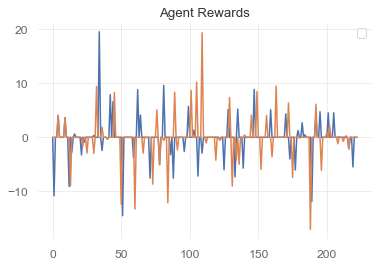

In [26]:
plt.plot(ppo_rewards)
plt.plot(a2c_rewards)

plt.legend()
plt.title('Agent Rewards')
plt.show()

In [61]:
model1 = PPO('MlpPolicy', env, verbose=1)
#model2 = A2C('MlpPolicy', env, verbose=1)
model1.learn(total_timesteps=1000)

Using cpu device


C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, inf

-----------------------------
| time/              |      |
|    fps             | 3954 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 4096 |
-----------------------------


In [62]:
obs = env.reset()

while True:
    action, _ = model1.predict(obs)

    obs, reward, done, info = env.step(action)

    #env.render()
    
    if done.all():
        print("info:", info)
        break

info: [{'total_reward': 189.7199478149414, 'total_profit': 0.03317069051685119, 'position': 1, 'TimeLimit.truncated': False, 'terminal_observation': array([[ 4.12329987e+02, -3.13000488e+00],
       [ 4.11970001e+02, -3.59985352e-01],
       [ 4.14200012e+02,  2.23001099e+00],
       [ 4.16079987e+02,  1.87997437e+00],
       [ 4.16850006e+02,  7.70019531e-01],
       [ 4.13290009e+02, -3.55999756e+00],
       [ 4.08010010e+02, -5.27999878e+00],
       [ 4.11079987e+02,  3.06997681e+00],
       [ 4.16279999e+02,  5.20001221e+00],
       [ 4.22130005e+02,  5.85000610e+00]])}, {'total_reward': -21.39013671875, 'total_profit': 0.10332333842163377, 'position': 1, 'TimeLimit.truncated': False, 'terminal_observation': array([[ 3.80279999e+02,  1.29000854e+00],
       [ 3.80540009e+02,  2.60009766e-01],
       [ 3.80519989e+02, -2.00195312e-02],
       [ 3.78369995e+02, -2.14999390e+00],
       [ 3.78589996e+02,  2.20001221e-01],
       [ 3.79089996e+02,  5.00000000e-01],
       [ 3.73100006e

C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


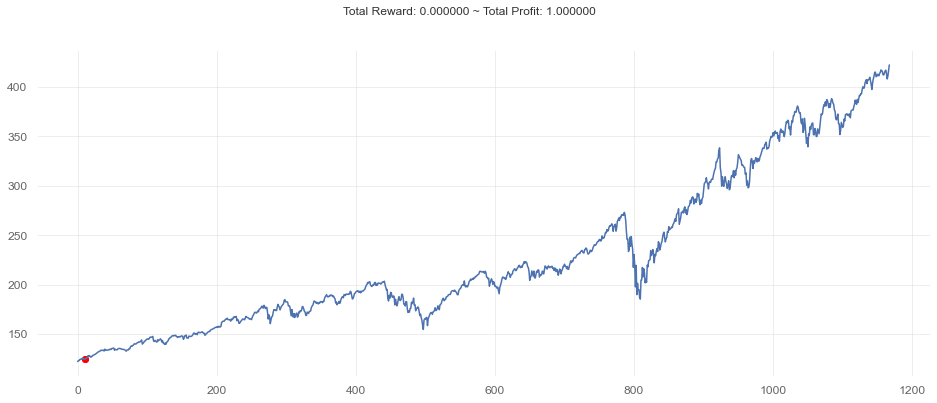

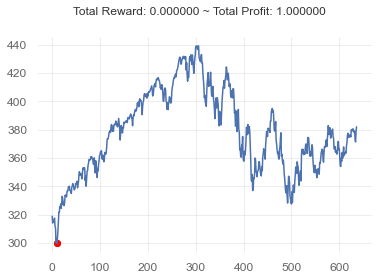

In [63]:
plt.figure(figsize=(16, 6))
for env in envs:
    env.render()
plt.show()

In [56]:
env.history

{}

In [54]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=data.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)

KeyError: 'total_profit'